In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 47.4 MB/s 
     |████████████████████████████████| 6.8 MB 34.8 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
     |████████████████████████████████| 895 kB 29.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
import random

In [ ]:
!wget https://raw.githubusercontent.com/vishalrk1/pytorch/main/Pytorch_Helper.py
from Pytorch_Helper import LabelEncoder, Tokenizer, Trainer

--2022-01-30 09:30:02--  https://raw.githubusercontent.com/vishalrk1/pytorch/main/Pytorch_Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘Pytorch_Helper.py’

Pytorch_Helper.py   100%[===================>]  10.76K  --.-KB/s    in 0s      

2022-01-30 09:30:02 (41.3 MB/s) - ‘Pytorch_Helper.py’ saved [11016/11016]



In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64
max_length = 128

cuda


# Converting text abstracts to dataset

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [ ]:
def preprocess_text_with_line_number(filename):
  """
  returns a list of dictionary of lines data
  
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
    
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
       abstract_lines += line

  return abstract_samples


# getting data from file and preocess it
train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')

# convertind dictionary lists into pandas dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


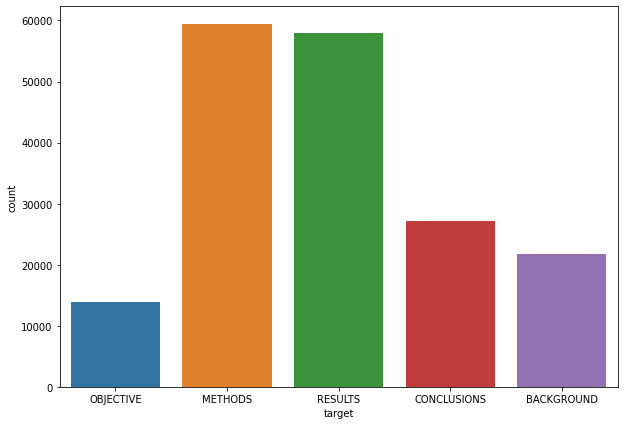

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot('target',data=train_df);

# Preprocessing Data

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in paranthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text


# Apply to dataframe
preprocessed_df = train_df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess)
print (f"{train_df.text.values[0]}\n\n{preprocessed_df.text.values[0]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we']
to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .

investigate efficacy weeks daily low dose oral prednisolone improving pain mobility systemic low grade inflammation short term whether effect would sustained weeks older adults moderate severe knee osteoarthritis


In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

# Spliting Dataset into train, test and validation dataset

In [ ]:
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.7
VAL_SIZE = 0.20
TEST_SIZE = 0.10

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Data
X = preprocessed_df["text"].values
y = preprocessed_df["target"].values

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)

print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (126027,), y_train: (126027,)
X_val: (27006,), y_val: (27006,)
X_test: (27007,), y_test: (27007,)
Sample point: surgeons abandoned use drains placed pancreas resection → BACKGROUND


# Label Encoder

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
print(NUM_CLASSES)

label_encoder.class_to_index

class_names = label_encoder.class_to_index.keys()
class_names

5


dict_keys(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

In [ ]:
train_df['target'].values

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [ ]:
# Converting all targets into numbers
y_train = label_encoder.encode(train_df['target'].values)
y_val = label_encoder.encode(val_df['target'].values)
y_test = label_encoder.encode(test_df['target'].values)

# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [21727 27168 59353 13839 57953]
weights: {0: 4.6025682330740555e-05, 1: 3.680800942285041e-05, 2: 1.684834801947669e-05, 3: 7.225955632632416e-05, 4: 1.7255362103773747e-05}


# Tokenizer

In [ ]:
from transformers import DistilBertModel, DistilBertTokenizerFast, AdamW

In [ ]:
model_name = 'distilbert-base-uncased'

bert_model = DistilBertModel.from_pretrained(model_name)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [ ]:
tokenized_text = tokenizer.encode_plus(train_sentences[0], return_tensors='pt', max_length=128, padding='max_length', truncation=True)

In [ ]:
tokenized_text['input_ids'].shape

torch.Size([1, 128])

In [ ]:
output = bert_model(tokenized_text['input_ids'], attention_mask = tokenized_text['attention_mask'])

In [ ]:
final_output = output[0][:,0,:].view(-1, 768)
final_output.shape

torch.Size([1, 768])

In [ ]:
from transformers import BertModel, BertTokenizerFast

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Skimlit Dataset

In [ ]:
class SkimlitDataset(Dataset):
  def __init__(self, text_seq, line_num, total_lines, target, tokenizer):
    self.text_seq = text_seq
    self.line_num = line_num
    self.total_lines = total_lines
    self.target = target
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.target)

  def __str__(self):
    return f"<Dataset(N={len(self)})>"
  
  def __getitem__(self, index):
    text = self.text_seq[index]
    line_num = self.line_num[index]
    total_lines = self.total_lines[index]
    target = self.target[index]

    return [text, line_num, total_lines, target]

  def collate_fn(self, batch):
    """Processing on a batch"""
    # Getting Input
    batch = np.array(batch)
    texts = batch[:,0]
    # print(texts.tolist())
    line_nums = batch[:, 1]
    total_lines = batch[:, 2]
    target = batch[:, 3]

    # converting line nums into one-hot encoding
    line_nums = tf.one_hot(line_nums, depth=20)

    # converting total lines into one-hot encoding
    total_lines = tf.one_hot(total_lines, depth=24)

    # tokenizing text inputs
    tokenized_text = self.tokenizer(texts.tolist(), return_tensors='pt', max_length=128, padding='max_length', truncation=True)

    # input_ids = tokenized_text['input_ids']
    # attention_mask = tokenized_text['attention_mask']
    line_nums = torch.tensor(line_nums.numpy())
    total_lines = torch.tensor(total_lines.numpy())
    target = torch.LongTensor(target.astype(np.int32))

    return tokenized_text, line_nums, total_lines, target

  def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
    dataloader = DataLoader(dataset=self, batch_size=batch_size, collate_fn=self.collate_fn, shuffle=shuffle, drop_last=drop_last, pin_memory=True)
    return dataloader


In [ ]:
train_dataset = SkimlitDataset(text_seq=train_df['text'].values, line_num=train_df['line_number'], total_lines=train_df['total_lines'], target=y_train, tokenizer=tokenizer)
val_dataset = SkimlitDataset(text_seq=val_df['text'].values, line_num=val_df['line_number'], total_lines=val_df['total_lines'], target=y_val, tokenizer=tokenizer)
test_dataset = SkimlitDataset(text_seq=test_df['text'].values, line_num=test_df['line_number'], total_lines=test_df['total_lines'], target=y_test, tokenizer=tokenizer)

In [ ]:
train_dataset[0]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 0,
 11,
 3]

In [ ]:
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=2, pin_memory=True)
# val_dataloader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=2, pin_memory=True)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, num_workers=2, pin_memory=True)

train_dataloader = train_dataset.create_dataloader(batch_size=64)
val_dataloader = val_dataset.create_dataloader(batch_size=64)
test_dataloader = test_dataset.create_dataloader(batch_size=64)

In [ ]:
batch = next(iter(train_dataloader))

# tokenized_text, total_lines

In [ ]:
tokenized_text, line_nums, total_lines = batch[:-1]

In [ ]:
tokenized_text['input_ids'] = tokenized_text['input_ids'].to(device)
tokenized_text['attention_mask'] = tokenized_text['attention_mask'].to(device)
tokenized_text

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'input_ids': tensor([[  101,  1106,  8242,  ...,     0,     0,     0],
         [  101,   170,  1703,  ...,     0,     0,     0],
         [  101,  9386,  5252,  ...,     0,     0,     0],
         ...,
         [  101,  2962, 16756,  ...,     0,     0,     0],
         [  101,  1107,  1241,  ...,     0,     0,     0],
         [  101,  1175,  1127,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]])}

# Skimlit-Transformers Model

In [ ]:
def gather_last_relevant_hidden(hiddens, seq_lens):
    """Extract and collect the last relevant
    hidden state based on the sequence length."""
    seq_lens = seq_lens.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(seq_lens):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

In [ ]:
class SkimlitModel(nn.Module):
  def __init__(self, num_classes, freeze_bert=True):
    super(SkimlitModel, self).__init__()

    # Initalizing BERT Model
    self.base_model = BertModel.from_pretrained('bert-base-cased')

    if freeze_bert:
      for param in self.base_model.parameters():
        param.requires_grad = False

    # FC layers
    self.fc_text = nn.Linear(768, 512)

    self.fc_line_num = nn.Linear(20, 64)
    self.fc_total_line = nn.Linear(24, 64)

    self.fc_final = nn.Linear((64+64+512), 128)
    self.classifier = nn.Linear(128, num_classes)
    self.dropout = nn.Dropout(0.3)

  def forward(self, text_inputs, line_nums, total_lines):

    # bert model output
    bert_output = self.base_model(**text_inputs)
    x_1 = bert_output['pooler_output']

    # FC layers output
    x_1 = F.relu(self.fc_text(x_1))
    x_2 = F.relu(self.fc_line_num(line_nums))
    x_3 = F.relu(self.fc_total_line(total_lines))

    x = torch.cat((x_1, x_2, x_3), dim=1)
    x = self.dropout(x)
    x = F.relu(self.fc_final(x))
    x = self.dropout(x)
    x = self.classifier(x)
    return x

In [ ]:
model = SkimlitModel(num_classes=NUM_CLASSES)
model = model.to(device)
model

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SkimlitModel(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-4)

# class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Trainer

In [ ]:
# Model training
from tqdm.notebook import tqdm

epochs = 10
patience = 3
save_path='/content/drive/MyDrive/Datasets/skimlit-pytorch-transformers-1.pt'

results = {
    'train_losses': [],
    'valid_losses': [],
    'train_acc': [],
    'valid_acc': [],
}

best_val_loss = np.inf

for epoch in range(epochs):
  print(f'<----- Epoch: {epoch+1} ----->')
  train_loss = 0
  valid_loss = 0

  train_acc = 0
  valid_acc = 0

  # training model on training dataset
  model.train()
  for batch in tqdm(train_dataloader, total=len(train_dataloader)):

    text_seq, line_nums, total_lines, labels = batch

    input_ids, attention_mask = text_seq['input_ids'].to(device), text_seq['attention_mask'].to(device)
    line_nums, total_lines, labels = line_nums.to(device), total_lines.to(device), labels.to(device)

    inputs = {'input_ids':input_ids, 'attention_mask': attention_mask}

    optimizer.zero_grad()

    output = model.forward(inputs, line_nums, total_lines)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    train_acc += (output_class == labels).sum().item()/len(output)

  # evaluating model on validation dataset
  model.eval()
  for batch in tqdm(val_dataloader, total=len(val_dataloader)):
    
    text_seq, line_nums, total_lines, labels = batch

    input_ids, attention_mask = text_seq['input_ids'].to(device), text_seq['attention_mask'].to(device)
    line_nums, total_lines, labels = line_nums.to(device), total_lines.to(device), labels.to(device)

    inputs = {'input_ids':input_ids, 'attention_mask': attention_mask}

    output = model(inputs, line_nums, total_lines)
    loss = criterion(output, labels)

    valid_loss += loss.item()

    output_class = torch.softmax(output, dim=1).argmax(dim=1)
    valid_acc += (output_class == labels).sum().item()/len(output)

  # calculating losses
  train_loss = train_loss / len(train_dataloader)
  valid_loss = valid_loss / len(val_dataloader)

  # calculating accuracy
  train_acc = train_acc / len(train_dataloader)
  valid_acc = valid_acc / len(val_dataloader)

  scheduler.step(valid_loss)

  # Early stopping
  if valid_loss < best_val_loss:
    best_val_loss = valid_loss
    print('Saving Model!!')
    torch.save(model.state_dict(), save_path)
    _patience = patience  # reset _patience
  else:
    _patience -= 1
    if not _patience:  # 0
      print("Stopping early!")
      break

  # storing losses and accuracy
  results['train_losses'].append(train_loss)
  results['valid_losses'].append(valid_loss)
  results['train_acc'].append(train_acc)
  results['valid_acc'].append(valid_acc)

  print(f":learning_rate: {optimizer.param_groups[0]['lr']:.2E}")
  print('Training Loss: {:.6f} \tTraining Accuracy: {:.2f}'.format(train_loss, train_acc))
  print('Validation Loss: {:.6f} \tValidation Accuracy: {:.2f} \n'.format(valid_loss, valid_acc))

<----- Epoch: 1 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

Saving Model!!
:learning_rate: 1.00E-04
Training Loss: 0.809055 	Training Accuracy: 0.68
Validation Loss: 0.505729 	Validation Accuracy: 0.80 

<----- Epoch: 2 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

Saving Model!!
:learning_rate: 1.00E-04
Training Loss: 0.539947 	Training Accuracy: 0.79
Validation Loss: 0.427540 	Validation Accuracy: 0.84 

<----- Epoch: 3 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

Saving Model!!
:learning_rate: 1.00E-04
Training Loss: 0.488863 	Training Accuracy: 0.81
Validation Loss: 0.402968 	Validation Accuracy: 0.84 

<----- Epoch: 4 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

Saving Model!!
:learning_rate: 1.00E-04
Training Loss: 0.463040 	Training Accuracy: 0.82
Validation Loss: 0.379314 	Validation Accuracy: 0.85 

<----- Epoch: 5 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

Saving Model!!
:learning_rate: 1.00E-04
Training Loss: 0.446521 	Training Accuracy: 0.83
Validation Loss: 0.369293 	Validation Accuracy: 0.86 

<----- Epoch: 6 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

Saving Model!!
:learning_rate: 1.00E-04
Training Loss: 0.436343 	Training Accuracy: 0.83
Validation Loss: 0.358189 	Validation Accuracy: 0.86 

<----- Epoch: 7 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

:learning_rate: 1.00E-04
Training Loss: 0.427777 	Training Accuracy: 0.84
Validation Loss: 0.359195 	Validation Accuracy: 0.86 

<----- Epoch: 8 ----->


  0%|          | 0/2814 [00:00<?, ?it/s]

In [ ]:
# trainer = Trainer(model=model, device=device, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, save_path='/content/drive/MyDrive/Datasets/SkimLit/skimlit-pytorch-transformers-1.pt')

In [ ]:
# best_model = trainer.train(num_epochs=20, patience=5, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

In [ ]:
# test_loss, test_acc, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
# y_pred = np.argmax(y_prob, axis=1)
# print(f"Test Accuracy: {test_acc/len(test_dataloader)}")

In [ ]:
# y_pred

In [ ]:
# y_prob